In [1]:
import sys
sys.path.append("./scripts/")
import math
import numpy as np
from gridmap import*
from idealrobot import*
from matplotlib.animation import PillowWriter    #アニメーション保存用

In [2]:
class DWA(IdealRobot):
    def __init__(self, world):
        super().__init__(None, agent=None, sensor=None, color="black")
        self.world = world
        self.pose = np.append(self.world.start_index * self.world.grid_step + self.world.grid_step / 2, 0.0)
        self.poses = [self.pose]
        self.r = 0.05
        self.nu_acc = 0.1
        self.nu_min = 0.
        self.nu_max = 0.5
        self.nu_delta = 0.1
        self.omega_acc = 50*np.pi/180
        self.omega_min = -100*np.pi / 180
        self.omega_max = 100*np.pi / 180
        self.omega_delta = 5*np.pi/180
        self.time_interval = self.world.time_interval
        self.nu = 0.0
        self.omega = 0.0
    
    def resetRobot(self):
        self.pose = np.append(self.world.start_index * self.world.grid_step + self.world.grid_step / 2, 0.0)
    
    def draw(self, ax, elems):
        self.drawRobot(self.pose, ax, elems)
        self.drawTakenPath(self.poses, ax, elems)
        if self.isRobotInGoal(self.pose):
            return
        
        control_inputs = self.controlInputCandidate()
        path_candidates = self.pathCandidate(control_inputs)
        self.nu, self.omega = self.selectPath(path_candidates)
        
        self.drawPathCandidates(path_candidates, ax, elems)
        self.drawSelectedPath(self.pose, self.nu, self.omega, ax, elems)
        
        self.pose = self.state_transition(self.nu, self.omega, self.world.time_interval, self.pose)
        self.poses.append(self.pose)
    
    def run(self):
        self.resetRobot()
        while not self.isRobotInGoal(self.pose):
            self.pose = self.next(self.pose)
            self.poses.append(self.pose)
    
    def next(self, pose):
        control_inputs = self.controlInputCandidate()
        path_candidates = self.pathCandidate(control_inputs)
        self.nu, self.omega = self.selectPath(path_candidates)
        next_pose = self.state_transition(self.nu, self.omega, self.world.time_interval, self.pose)
        return next_pose
    
    def plot(self, figsize=(4, 4), save_path=None):
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')
        ax.set_xlim(0, self.world.grid_step[0] * self.world.grid_num[0])
        ax.set_ylim(0, self.world.grid_step[1] * self.world.grid_num[1])
        ax.set_xlabel("X", fontsize=10)
        ax.set_ylabel("Y", fontsize=10)

        # Map
        for index, grid in np.ndenumerate(self.world.grid_map):
            if grid == '0':  #Obstacle
                self.world.drawGrid(index, "black", 1.0, ax)
            if grid == '2' or self.world.isStart(index):  #Start
                self.world.drawGrid(index, "orange", 1.0, ax)
            elif grid == '3' or self.world.isGoal(index):  #Goal 
                self.world.drawGrid(index, "green", 1.0, ax)
                
        #Path
        ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        plt.show()

        if(save_path is not None):
            fig.savefig(save_path, bbox_inches='tight', pad_inches=0.1)
        return fig
    
    def controlInputCandidate(self):
        controlInput = []
        for omega in np.arange(self.omega-self.omega_acc, self.omega+self.omega_acc, self.omega_delta):
            for nu in np.arange(self.nu-self.nu_acc, self.nu+self.nu_acc+1e-5, self.nu_delta):
                if (nu < self.nu_max and nu > self.nu_min) and (omega < self.omega_max and omega > self.omega_min):
                    controlInput.append([nu, omega])
        return controlInput
    
    def pathCandidate(self, control_inputs):
        candidate_path = []
        for control_input in control_inputs:
            xs, ys, thetas = self.pose
            nu, omega = control_input
            path = [[xs, ys, thetas, 0.0, 0.0]]
            flag=0
            for i in range(5):
                xf, yf, thetaf = self.state_transition(nu, omega, self.world.time_interval, np.array([xs, ys, thetas]))
                if self.isRobotInObstacle([xf, yf, thetaf]):
                    flag=1
                    break
                path.append([xf, yf, thetaf, nu, omega])
                xs, ys, thetas = xf, yf, thetaf
            candidate_path.append(path) if flag==0 else None
        return candidate_path
    
    def selectPath(self, path_candidates):
        cost = float('inf')
        select_nu, select_omega = 0.0, 0.0
        for path in path_candidates:
            x, y, theta, nu, omega = path[-1]
            c = 0.1*self.costObstacle([x, y, theta]) + 10 * self.costSpeed(nu) + 500*self.costGoalDistance([x, y, theta])
            if(c < cost):
                cost = c
                select_nu, select_omega = nu, omega
        return select_nu, select_omega
    
    def costObstacle(self, pose):
        index = self.poseToIndex(pose)
        theta = pose[2]
        cost = 0.0
        for i in range(-2, 4):
            for j in range(-2, 4):
                if not self.isInRange(np.arctan2(j, i), theta-45, theta+45):
                    continue
                sensing_index = index + np.array([i, j])
                if self.world.isOutOfBounds(sensing_index):
                    continue
                if self.world.isObstacle(sensing_index):
                    cost += 1.0 / (np.linalg.norm(pose[0:2] - self.indexToPose(sensing_index)[0:2])+1e-5)
        return cost
    
    def costSpeed(self, nu):
        return 1.0 / (nu+1e-5)
    
    def costGoalDistance(self, pose):
        cost = np.linalg.norm(pose[0:2] - self.indexToPose(self.world.goal_index)[0:2])
        return cost
    
    def poseToIndex(self, pose):
        return (np.array(pose[0:2]) // self.world.grid_step).astype(np.int32)
    
    def indexToPose(self, index):
        return np.append(index * self.world.grid_step + self.world.grid_step / 2, 0.0)
    
    def isRobotInObstacle(self, pose):
        index = self.poseToIndex(pose)
        for grid in neigbor_grids:
            neigbor_index = index + grid
            if self.world.isObstacle(neigbor_index):
                dis = np.linalg.norm(pose[0:2] - self.indexToPose(neigbor_index)[0:2])
                if(dis < self.r/2 + self.world.grid_step[0]):
                    return True
        return False
    
    def isInRange(self, angle, rangeMin, rangeMax):
        if(rangeMin < rangeMax):
            if(angle >= rangeMin and angle < rangeMax):
                return True
            else:
                return False
        else:
            if(angle >= rangeMin):
                return True
            elif(angle < rangeMax):
                return True
            else:
                return False
    
    def isRobotInGoal(self, pose):
        index = self.poseToIndex(pose)
        if self.world.isGoal(index):
            return True
        else:
            return False
    
    def drawPathCandidates(self, path_candidates, ax, elems=None):
        for path in path_candidates:
            for i in range(len(path) - 1):
                xs, ys, _, _, _ = path[i]
                xf, yf, _, _, _ = path[i+1]
                if elems is None:
                    ax.plot([xs, xf], [ys, yf], color="cyan", lineWidth=0.4)
                else:
                    elems += ax.plot([xs, xf], [ys, yf], color="cyan", lineWidth=0.4)
    
    def drawSelectedPath(self, pose, nu, omega, ax, elems):
        xs, ys, thetas = pose
        for i in range(5):
            xf, yf, thetaf = self.state_transition(nu, omega, self.world.time_interval, np.array([xs, ys, thetas]))
            if elems is None:
                ax.plot([xs, xf], [ys, yf], color="red", lineWidth=1.0)
            else:
                elems += ax.plot([xs, xf], [ys, yf], color="red", lineWidth=1.0)
            xs, ys, thetas = xf, yf, thetaf

<IPython.core.display.Javascript object>


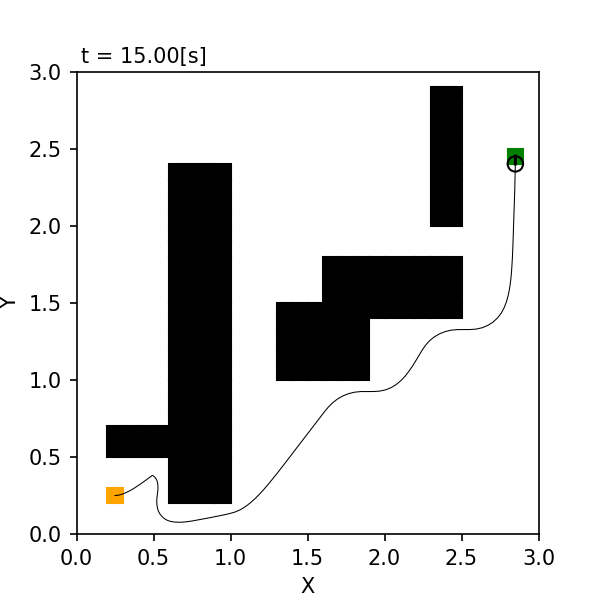

In [3]:
if __name__ == "__main__":
    time_span = 15
    time_interval = 0.1

    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])

    map_data = "./csvmap/map7.csv"

    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, time_show="time", debug=False)
    world.append(DWA(world))

    world.draw()
    #world.ani.save('dwa_map7.gif', writer='ffmpeg', fps=100)    #アニメーション保存